In [1]:
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


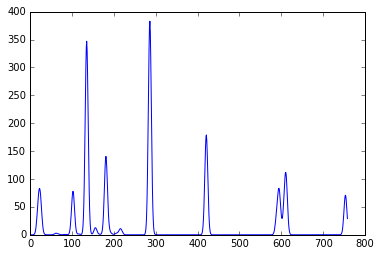

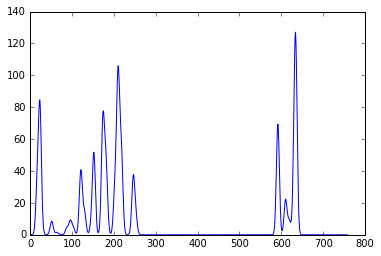

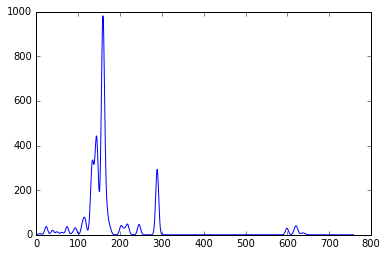

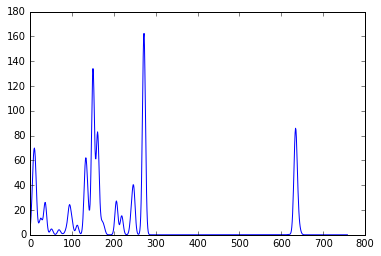

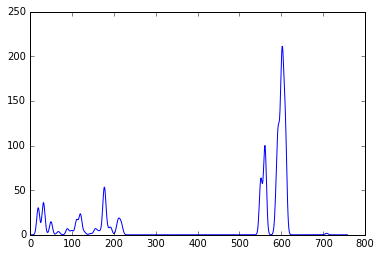

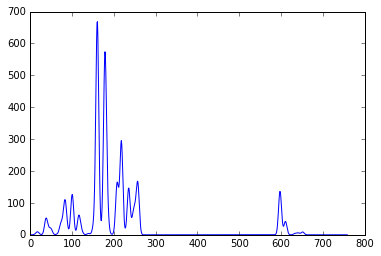

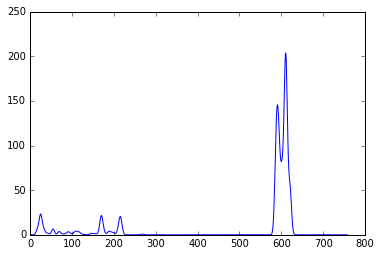

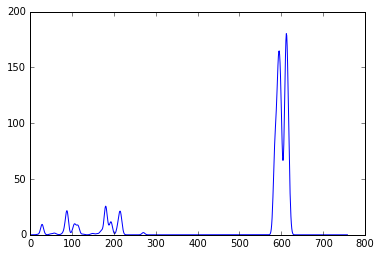

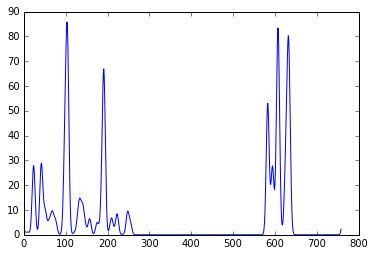

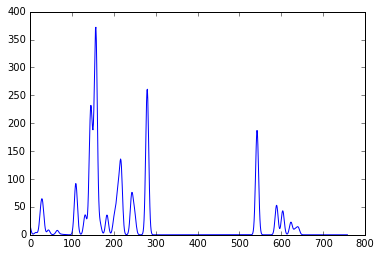

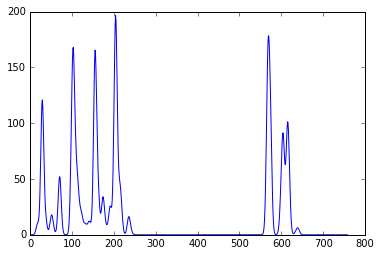

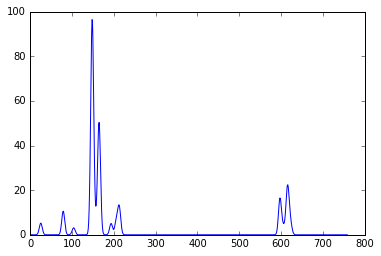

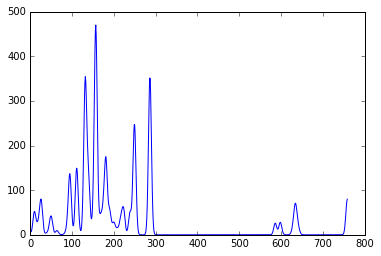

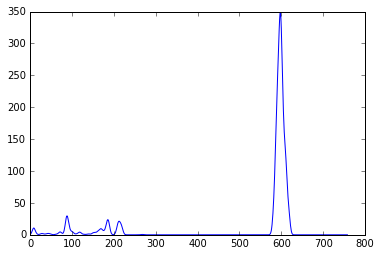

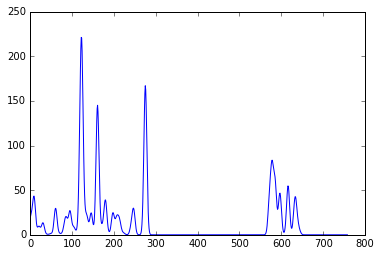

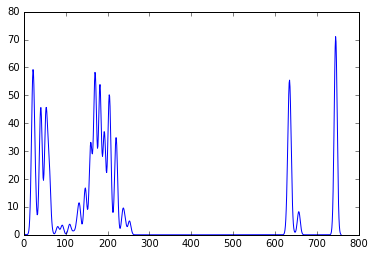

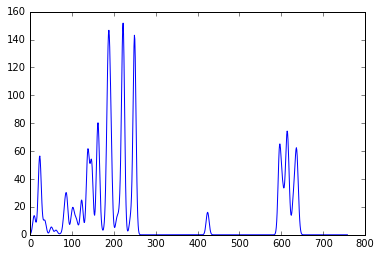

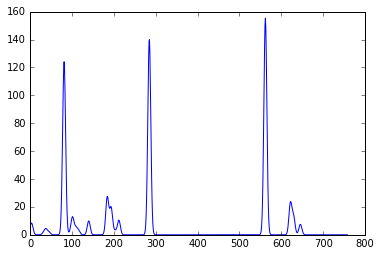

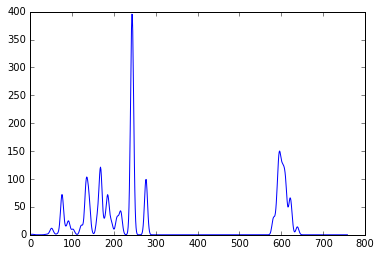

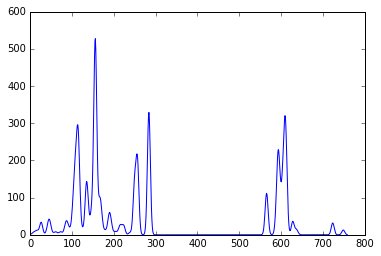

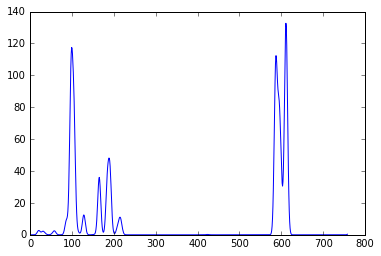

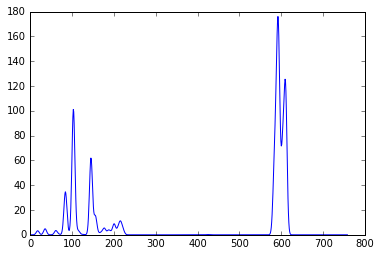

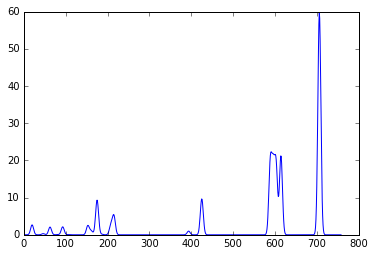

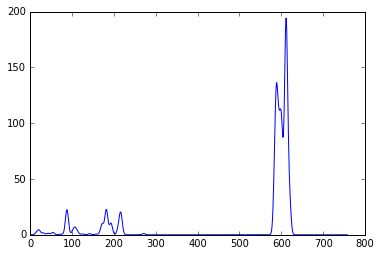

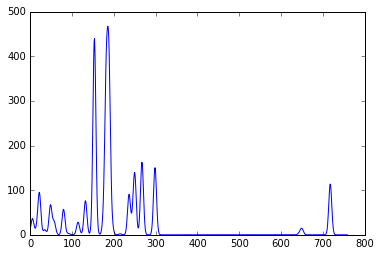

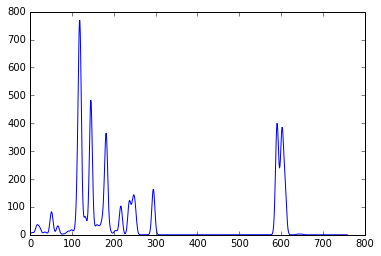

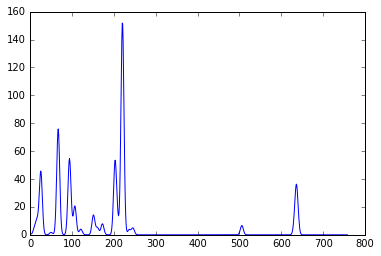

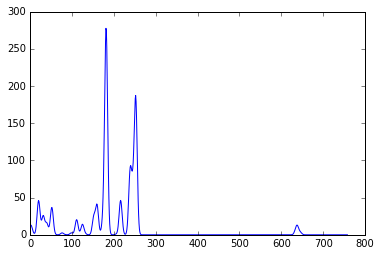

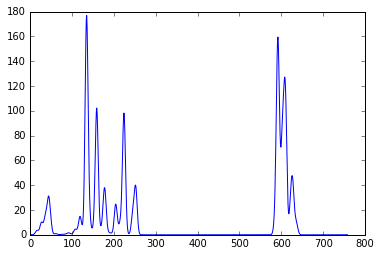

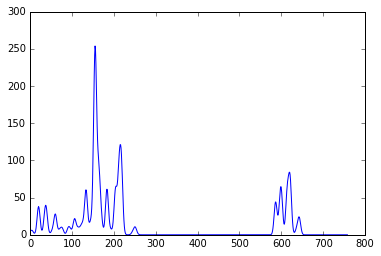

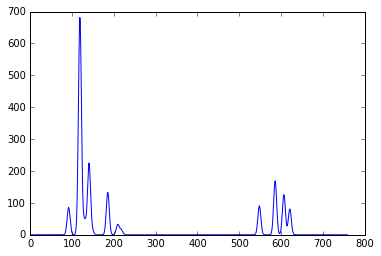

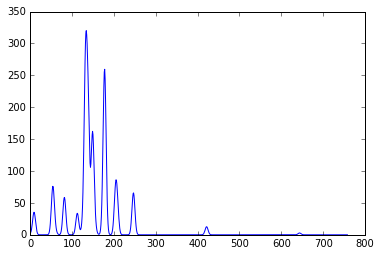

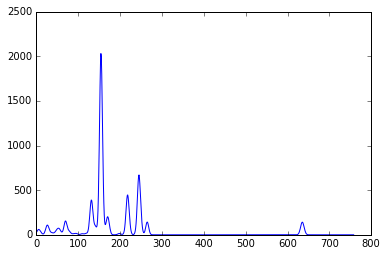

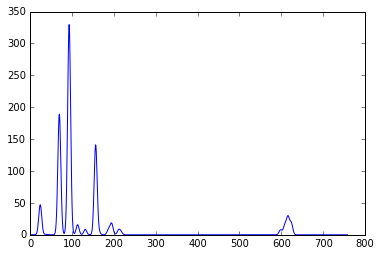

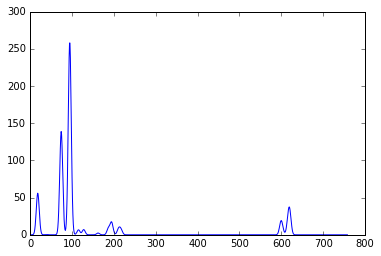

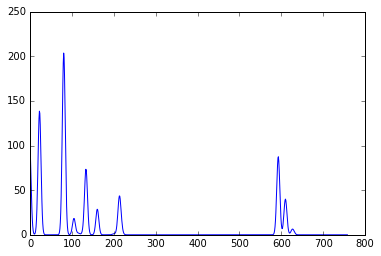

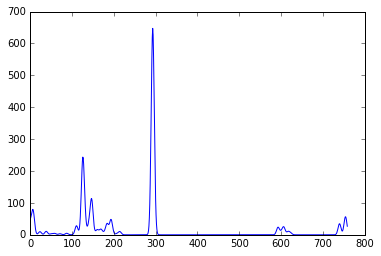

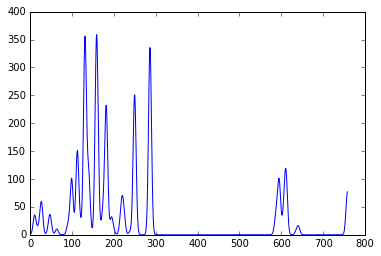

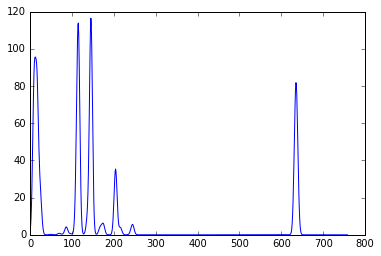

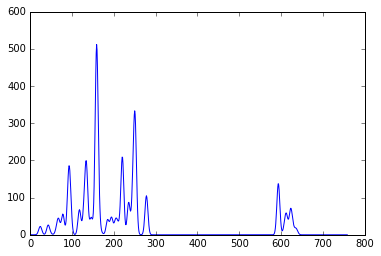

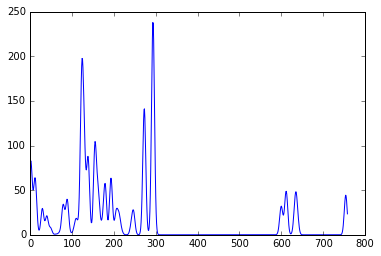

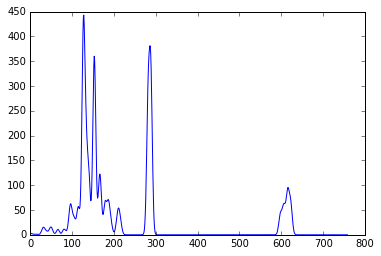

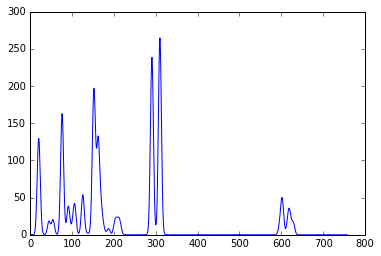

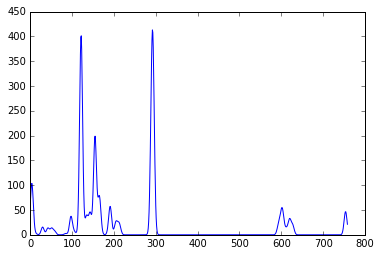

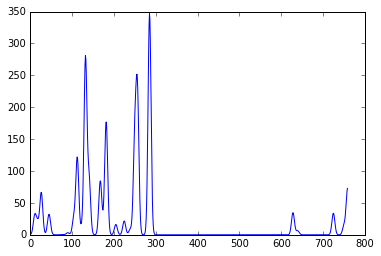

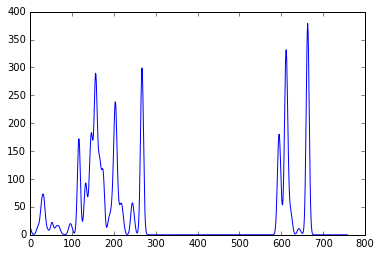

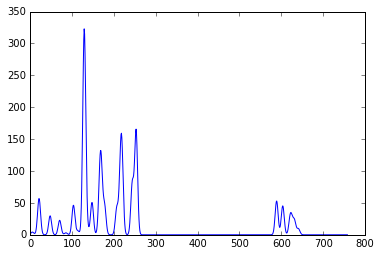

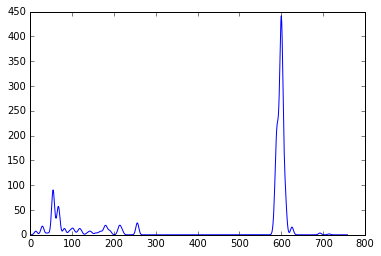

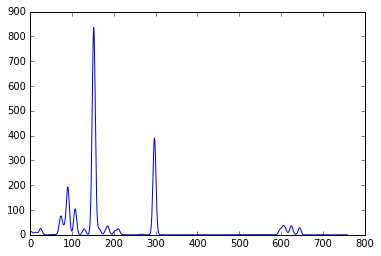

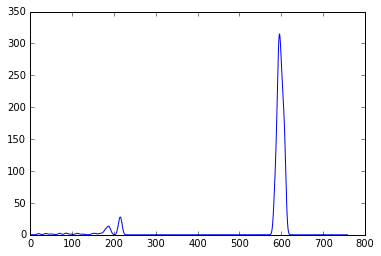

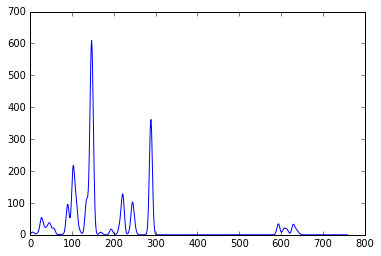

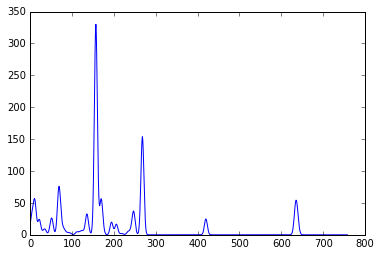

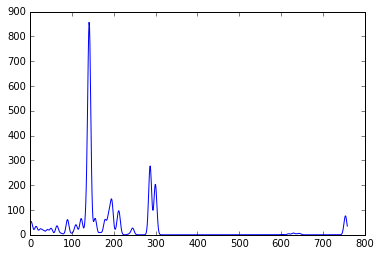

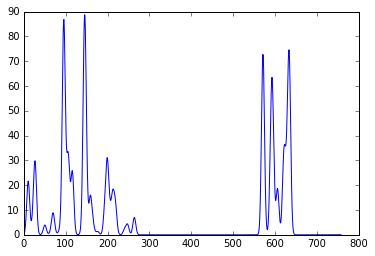

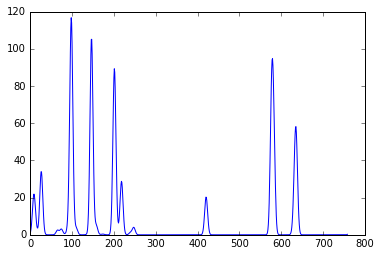

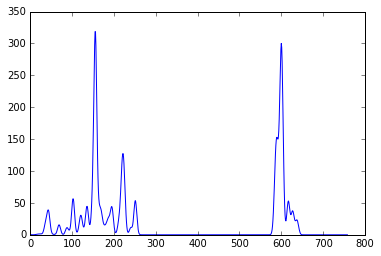

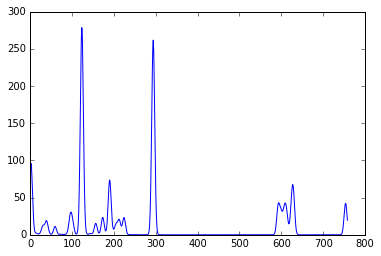

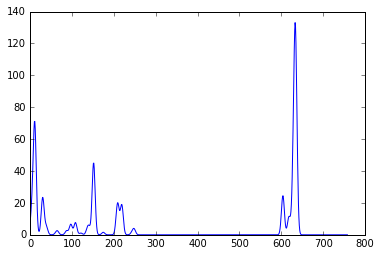

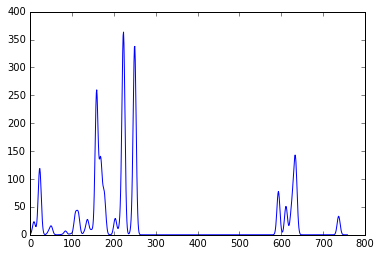

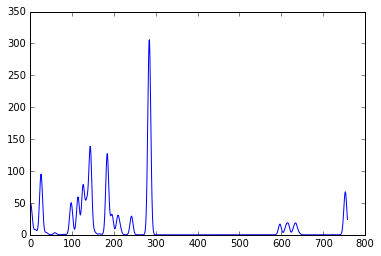

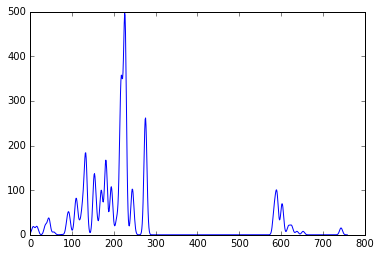

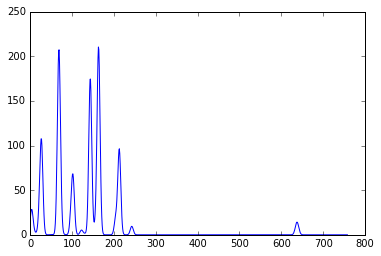

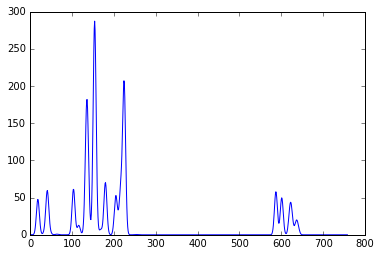

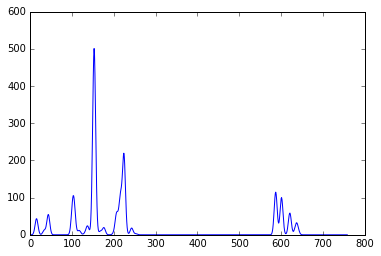

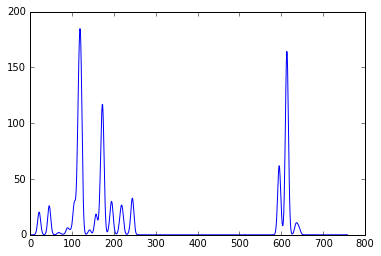

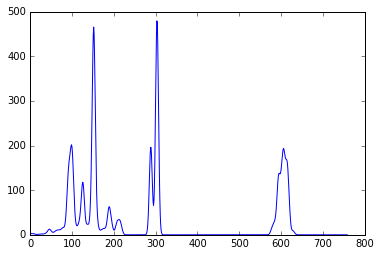

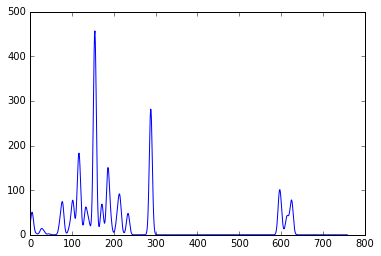

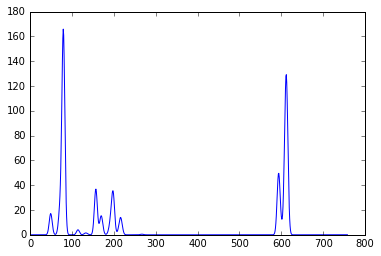

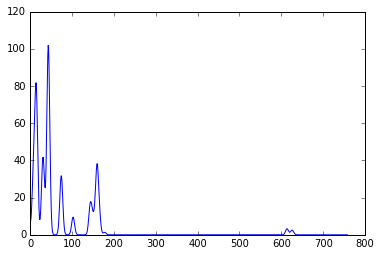

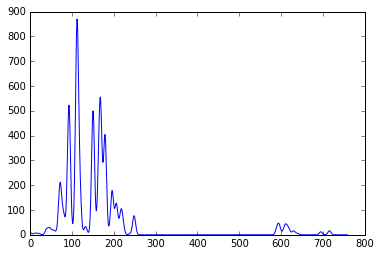

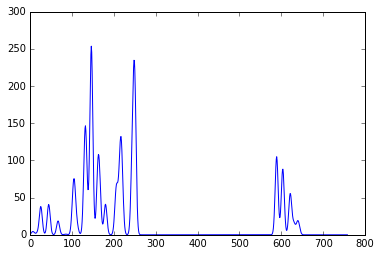

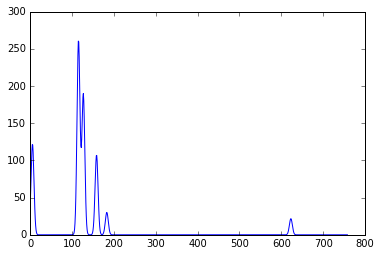

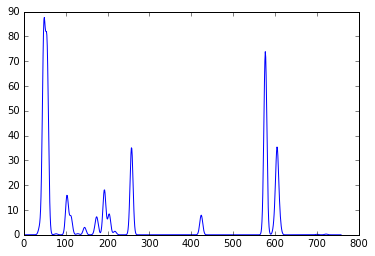

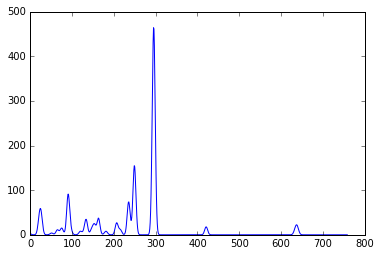

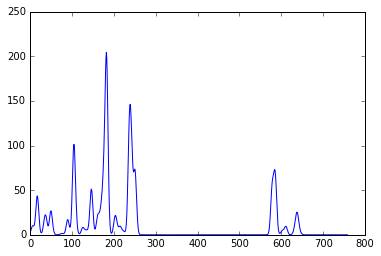

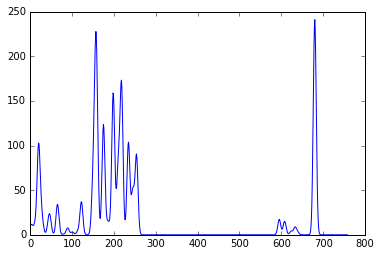

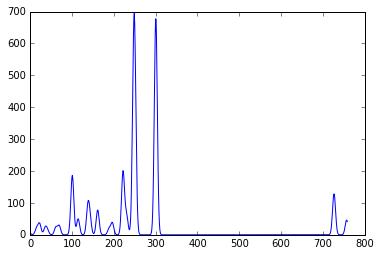

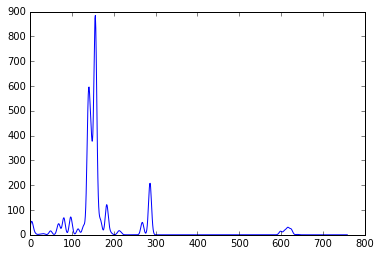

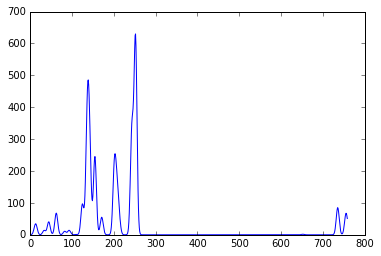

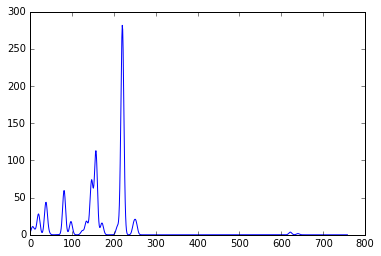

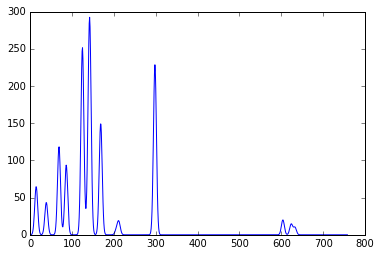

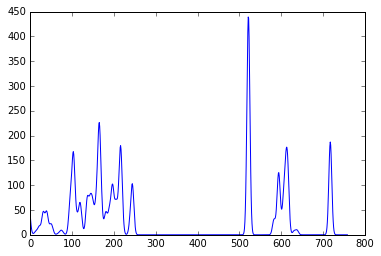

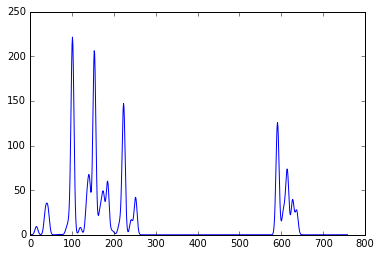

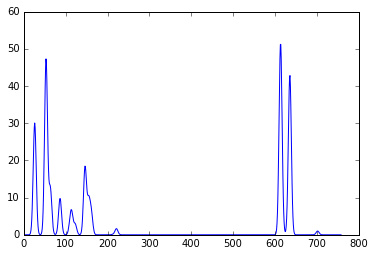

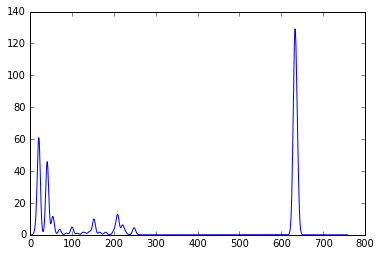

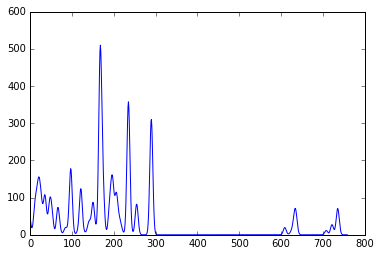

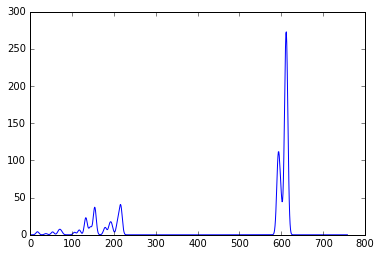

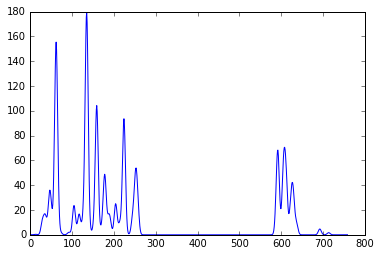

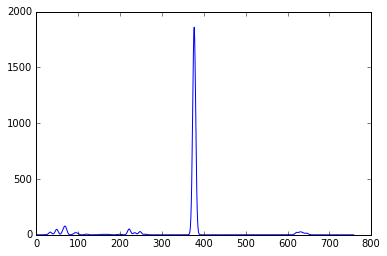

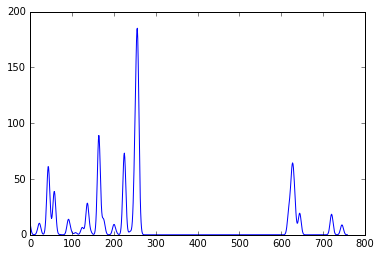

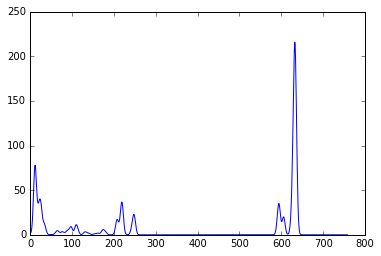

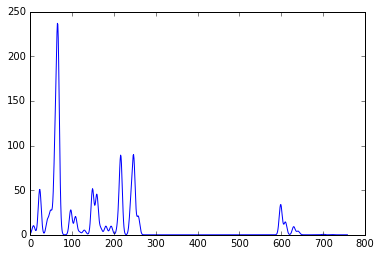

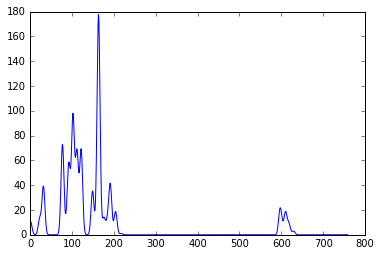

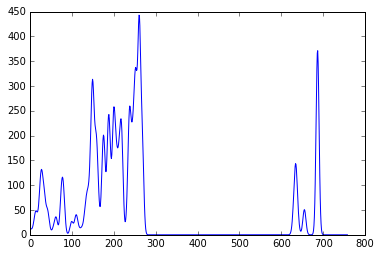

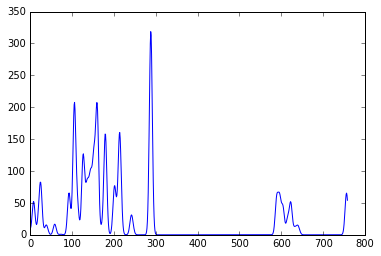

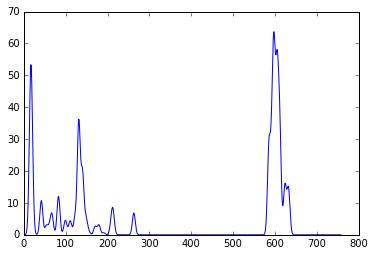

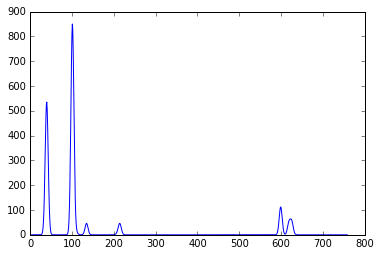

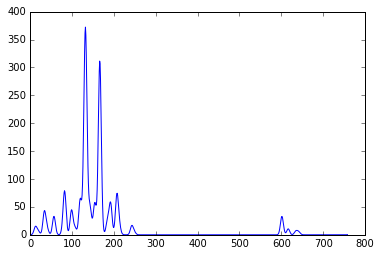

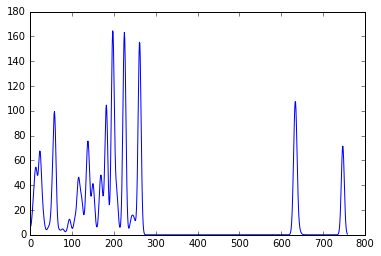

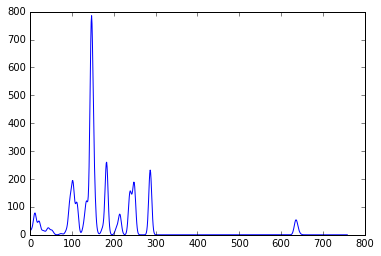

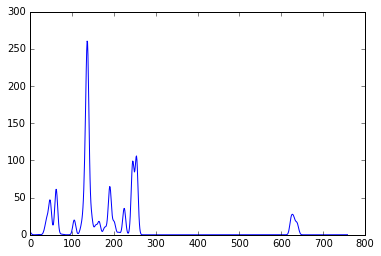

In [2]:
count = 100
with open("../../../target/thirs.txt") as f:
    for i in f:
        if count < 0:
            break
        plt.plot([float(y) for y in i.split()])
        plt.show()
        count -= 1